# Labelling for Spatial Orientation

In this notebook, we will automate labeling spatial orientation: upright, inverted, or horizontal; aerial, grounded, or floorwork; based on the position of the coordinates.

### Required Modules

In [25]:
import os
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

### Quick Image/Label Validation

First, we ensure that our existing labels match our coordinates data.

In [29]:
from src.data.preprocessing import validate_images_and_labels

directory = 'data/processed/source-ik/'
masterlist = pd.read_csv('data/processed/source-ik/masterlist.csv')
validate_images_and_labels(directory, masterlist)

All images and labels matched for 571 items


True

## X,Y Visualization
- Red for the head region
- Green for abdomen and shoulder regions
- Blue for lower region
- Cyan for feet regions

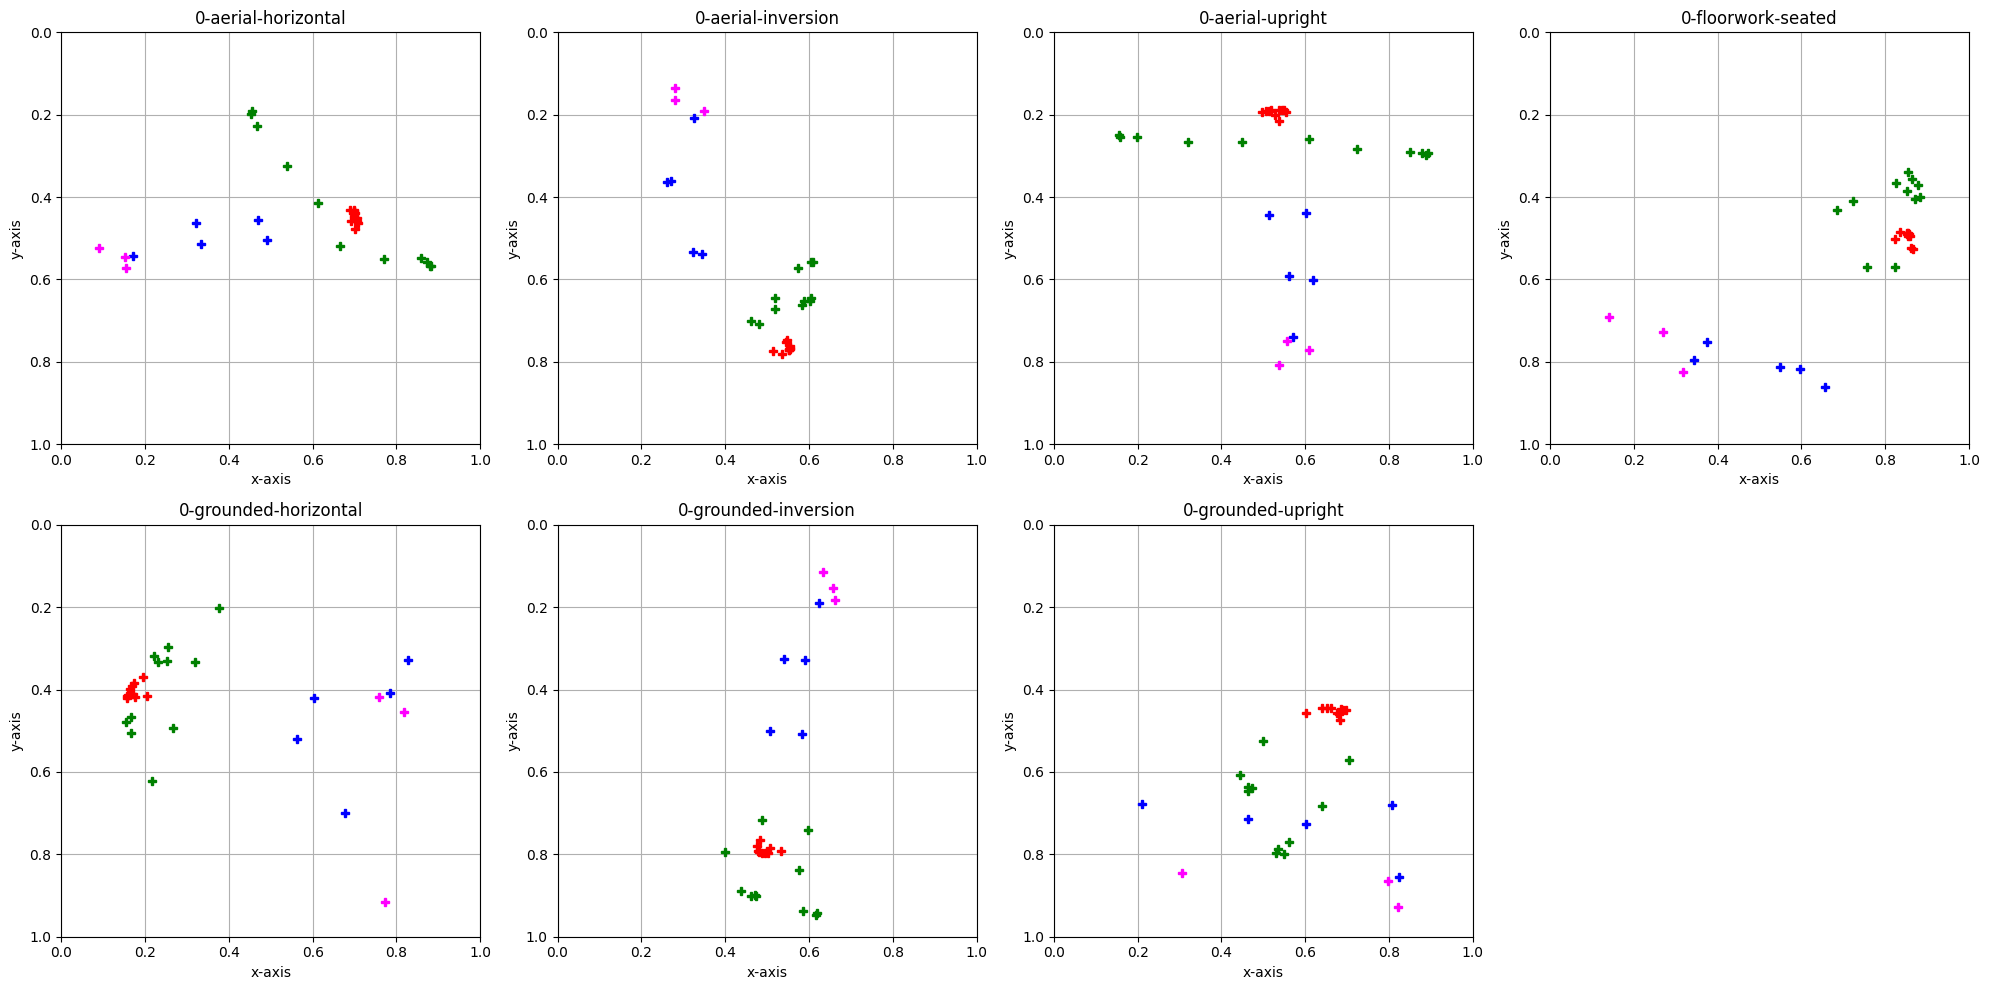

In [3]:
from src.data.plot_landmarks import batch_plot_pose_landmarks, batch_plot_pose_landmarks_agg

batch_plot_pose_landmarks('data/processed/source-ik/spatial', '0-')

## Identifying Patterns in Spatial Orientation

In the code below, we calculate averages for specific landmark points: the head, torso, right foot, and left foot. This process aids in discerning common postural tendencies and identifying alignment trends, facilitating automated labeling of postures.

**Observed Postural Tendencies:**
* **Inversion Orientation**: Characterized by the head's y-coordinate being lower than the torso's, and the torso's y-coordinate being lower than both feet's y-coordinates (head_y < torso_y < (right_foot_y, left_foot_y)).
* **Upright Orientation**: Defined by the head's y-coordinate being higher than the torso's, and the torso's y-coordinate being higher than both feet's y-coordinates (head_y > torso_y > (right_foot_y, left_foot_y)).
* **Horizontal Orientation**: Characterized by the sequential order of the x-coordinates for the head, torso, and feet (either head_x < torso_x < feet_x or the reverse). Additionally, it's marked by a minimal difference in the y-coordinates of the right and left feet, indicating a relatively level horizontal alignment of the feet.
* **Lateral Orientation**
* **Curled**
* **Tucked**

**Requires More Context:**

* **Grounded Horizontal Position**: Indicates a horizontal body alignment with the right and left feet positioned apart.
* Differentiating between **Aerial and Grounded Upright (or Inversion)** positions can be challenging without additional context such as the presence or absence of a "pole". In dance, generally dancers are encouraged to implement pointe techinique, which makes it harder to predict or visualize where the ground is. For example, a 180 degree between foot index to ankle can indicate standing position. In general, *pointed toes* is practiced which makes most "sole" data angled.

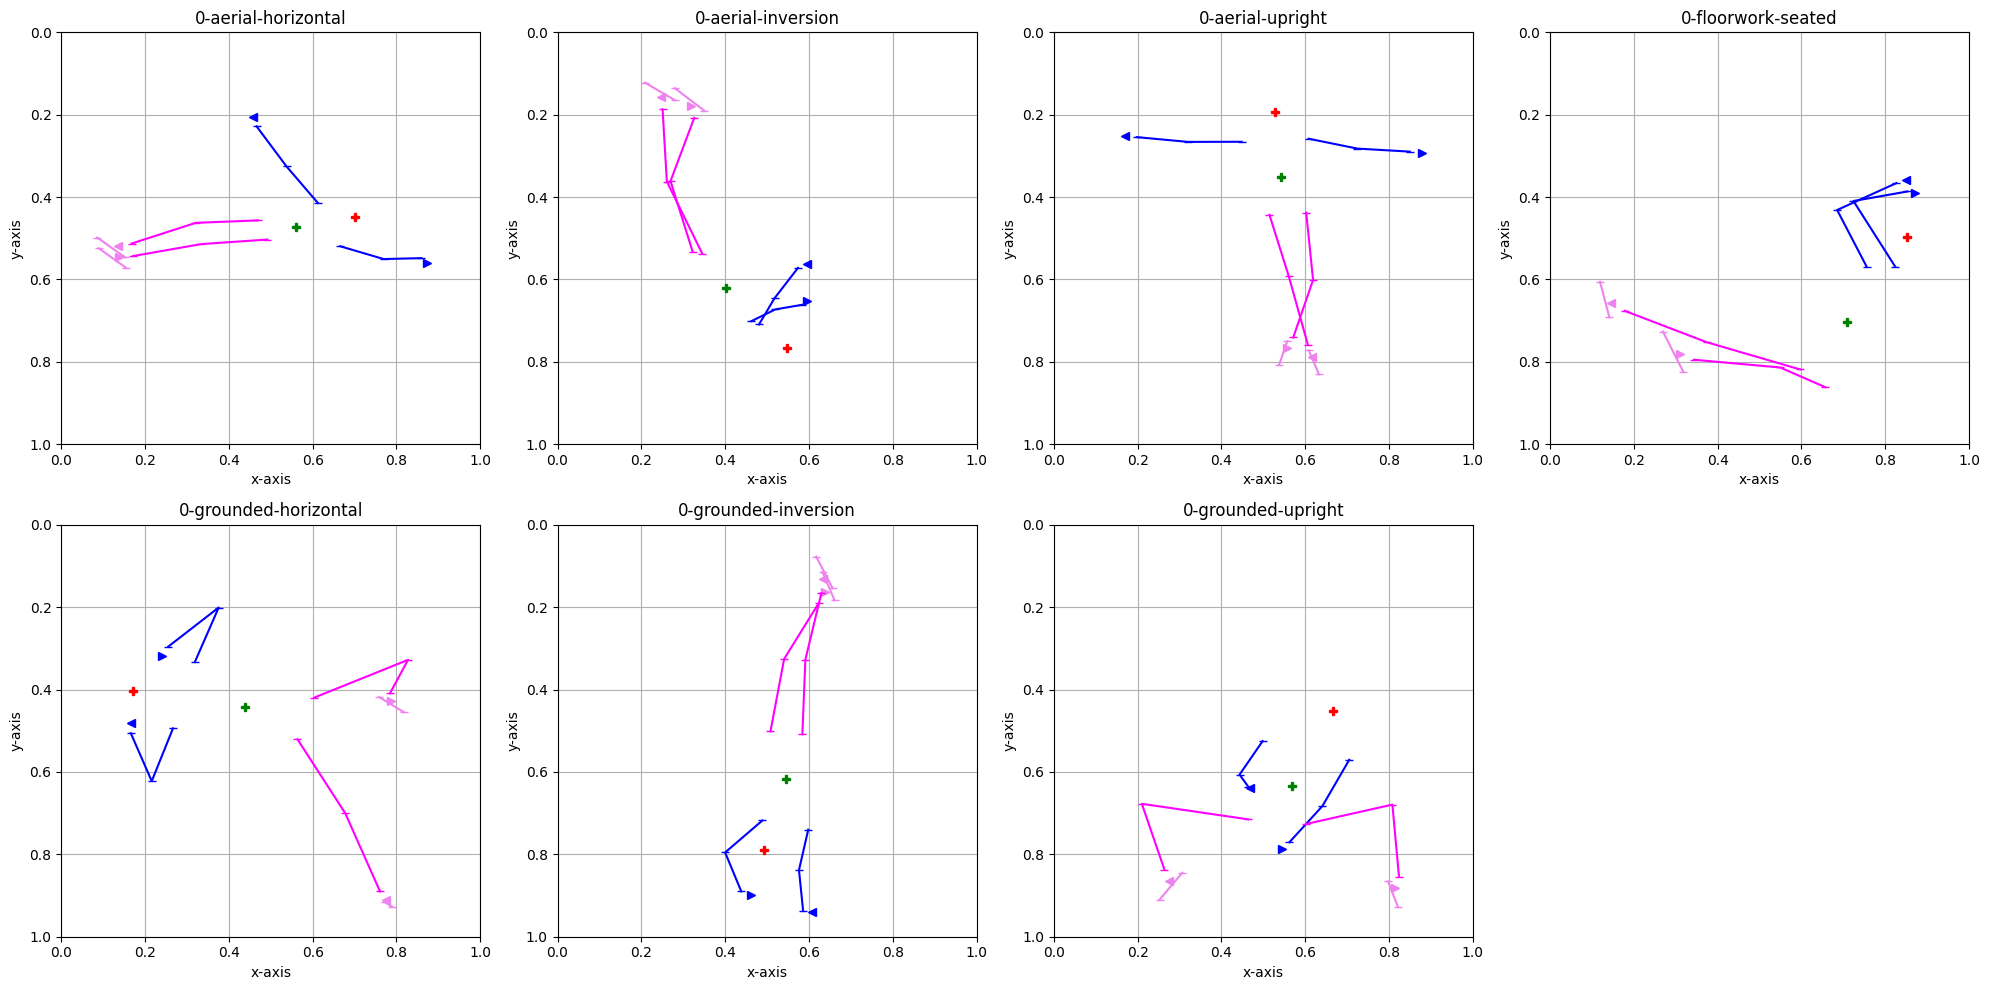

In [4]:
batch_plot_pose_landmarks_agg('data/processed/source-ik/spatial', '0-')

### Naive Classification (Drafted)
Here we'll implement a naive classification based on postural tendencies:

In [54]:
def classify_postures(input_dir, output_dir, some_threshold):
    # Create results directory with current date
    date_str = datetime.now().strftime("%m%d")  # Month and day
    results_dir = os.path.join(output_dir, f"spatial_orientation_{date_str}")
    os.makedirs(results_dir, exist_ok=True)

    # Subdirectories for each orientation
    orientations = ["inverted", "upright", "horizontal", "undefined", "lateral"]
    for orientation in orientations:
        os.makedirs(os.path.join(results_dir, orientation), exist_ok=True)

    # Loop through each .csv file
    for file in os.listdir(input_dir):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_dir, file))

            # Check if required columns exist
            if 'x' not in df.columns or 'y' not in df.columns:
                print(f"File {file} does not have the required 'x' or 'y' columns.")
                continue

            # Calculate averages for head, torso, and feet
            head_y = df['y'].iloc[0:10].mean()
            torso_y = df['y'].iloc[[11,12,24,23]].mean()
            feet_y = df['y'].iloc[[27, 28, 29, 30, 31, 32]].mean()
            
            head_x = df['x'].iloc[0:10].mean()
            torso_x = df['x'].iloc[[11,12,24,23]].mean()
            feet_x = df['x'].iloc[[27, 28, 29, 30, 31, 32]].mean()

            # Change constraints here
            if head_y < torso_y < feet_y:
                orientation = "upright"
            elif head_y > torso_y > feet_y:
                orientation = "inverted"
            elif abs(head_x - feet_x) < some_threshold and abs(torso_x - feet_x) < some_threshold:
                orientation = "lateral"
            elif (head_x < torso_x < feet_x) or (feet_x < torso_x < head_x):
                orientation = "horizontal"
            else:
                orientation = "undefined"

            # Move file to respective orientation folder
            shutil.copy(os.path.join(input_dir, file), os.path.join(results_dir, orientation, file))

In [55]:
classify_postures(directory, 'data/processed/', 0.12)

File masterlist.csv does not have the required 'x' or 'y' columns.


### Results

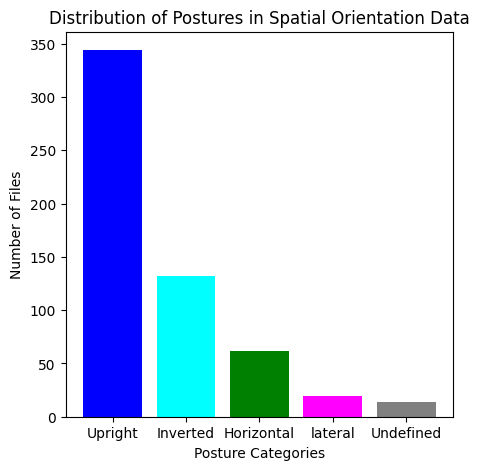

In [56]:
upright = [f for f in os.listdir('data/processed/spatial_orientation_1115/upright') if f.endswith('.csv')]
inverted = [f for f in os.listdir('data/processed/spatial_orientation_1115/inverted') if f.endswith('.csv')]
horizontal = [f for f in os.listdir('data/processed/spatial_orientation_1115/horizontal') if f.endswith('.csv')]
undefined = [f for f in os.listdir('data/processed/spatial_orientation_1115/undefined') if f.endswith('.csv')]
lateral = [f for f in os.listdir('data/processed/spatial_orientation_1115/lateral') if f.endswith('.csv')]

# Categories and their counts
categories = ['Upright', 'Inverted', 'Horizontal', 'lateral','Undefined']
counts = [len(upright), len(inverted), len(horizontal), len(lateral), len(undefined)]

# Creating the bar plot
plt.figure(figsize=(5, 5))
plt.bar(categories, counts, color=['blue', 'cyan','green', 'magenta', 'gray'])

plt.xlabel('Posture Categories')
plt.ylabel('Number of Files')
plt.title('Distribution of Postures in Spatial Orientation Data')
plt.xticks(categories)

# Show the plot
plt.show()

For visual inspection:

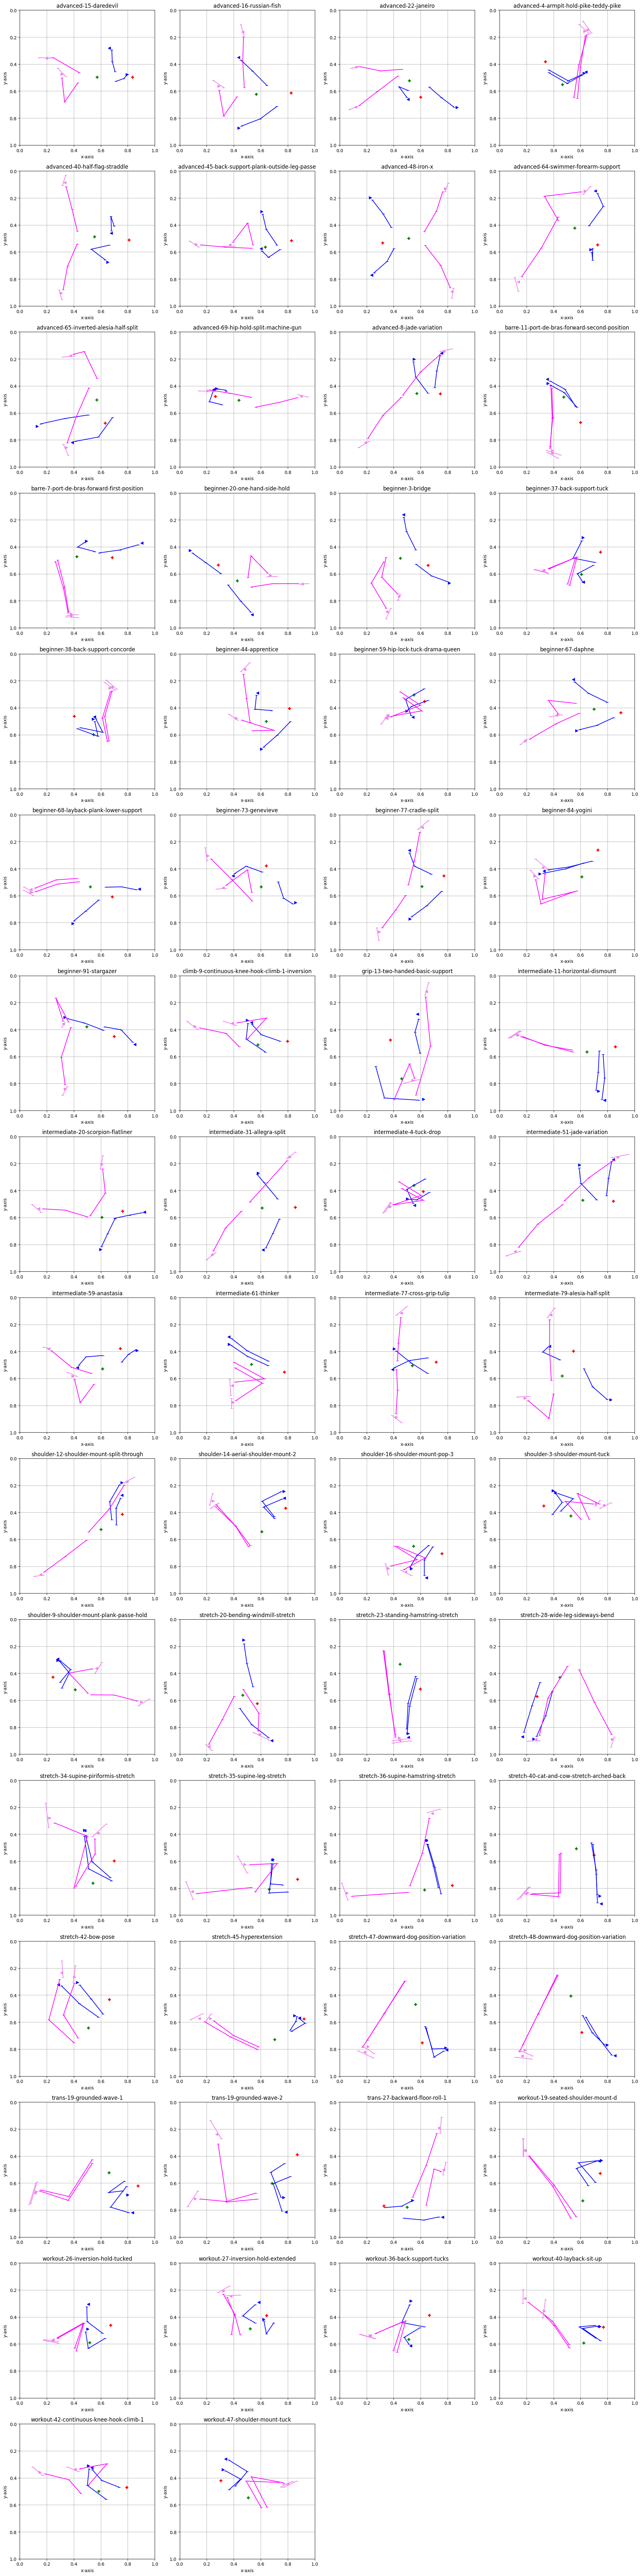

In [58]:
batch_plot_pose_landmarks_agg('data/processed/spatial_orientation_1115/horizontal', '')

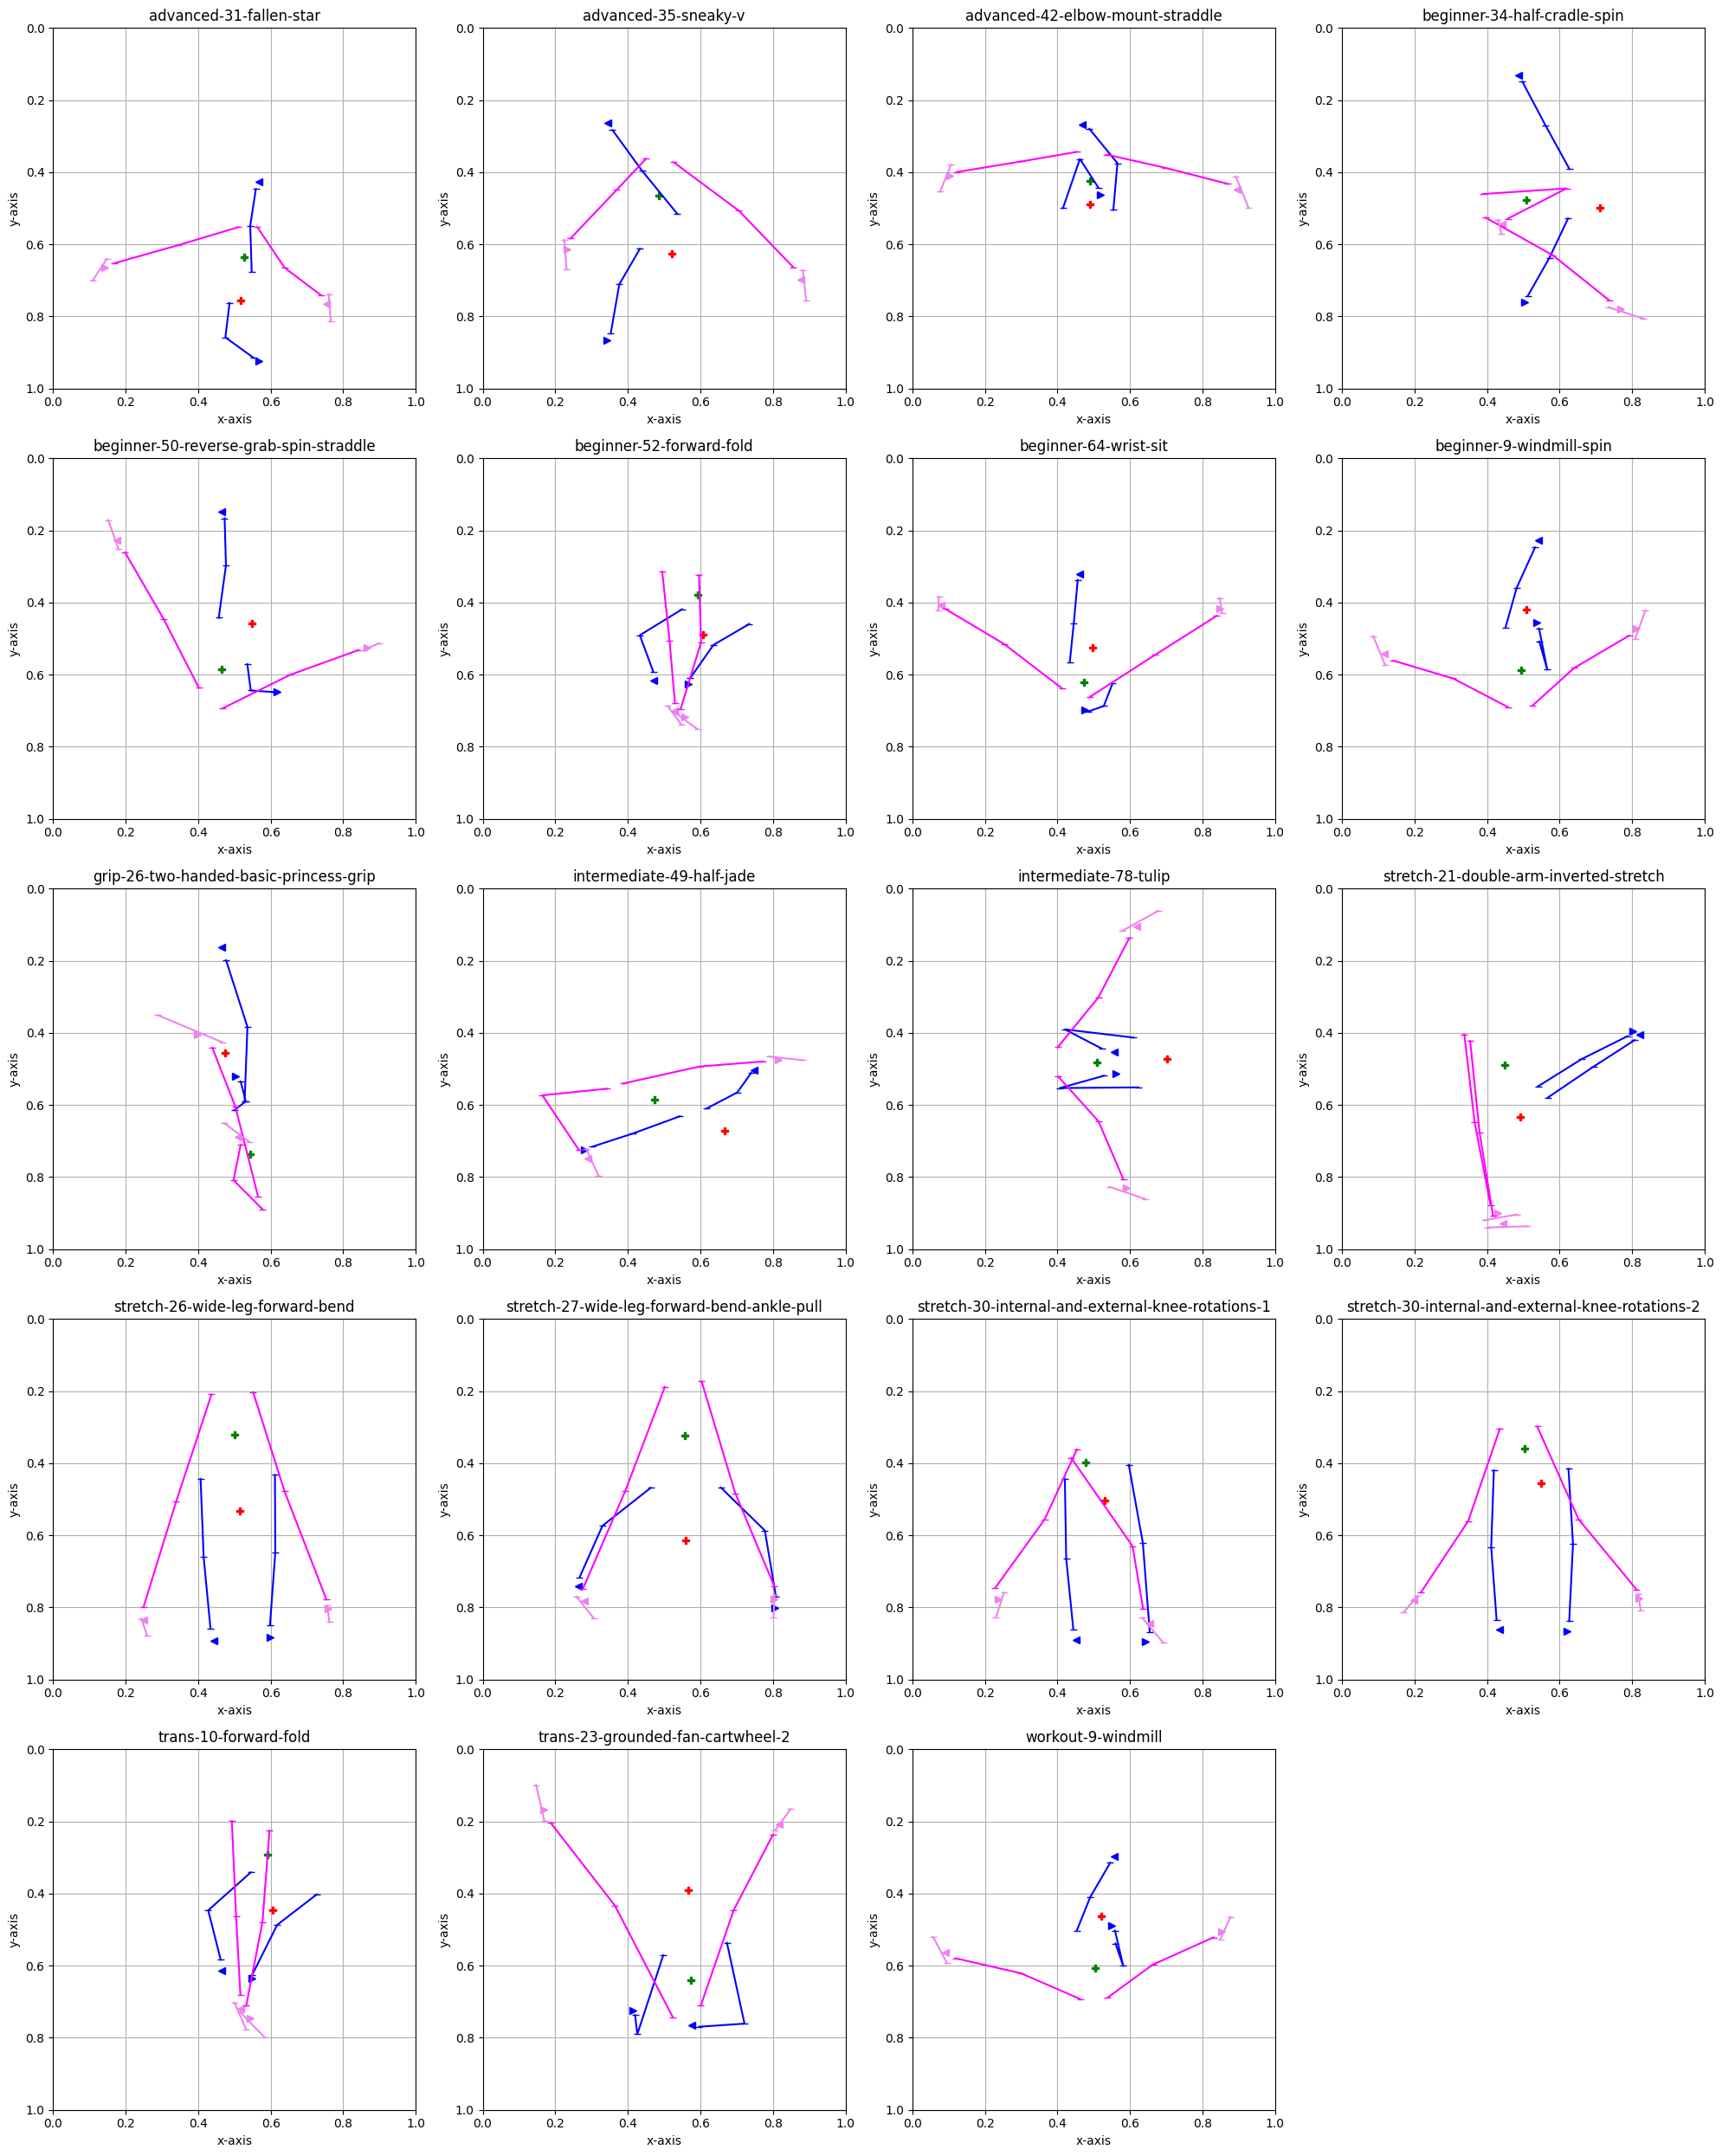

In [59]:
batch_plot_pose_landmarks_agg('data/processed/spatial_orientation_1115/lateral', '')

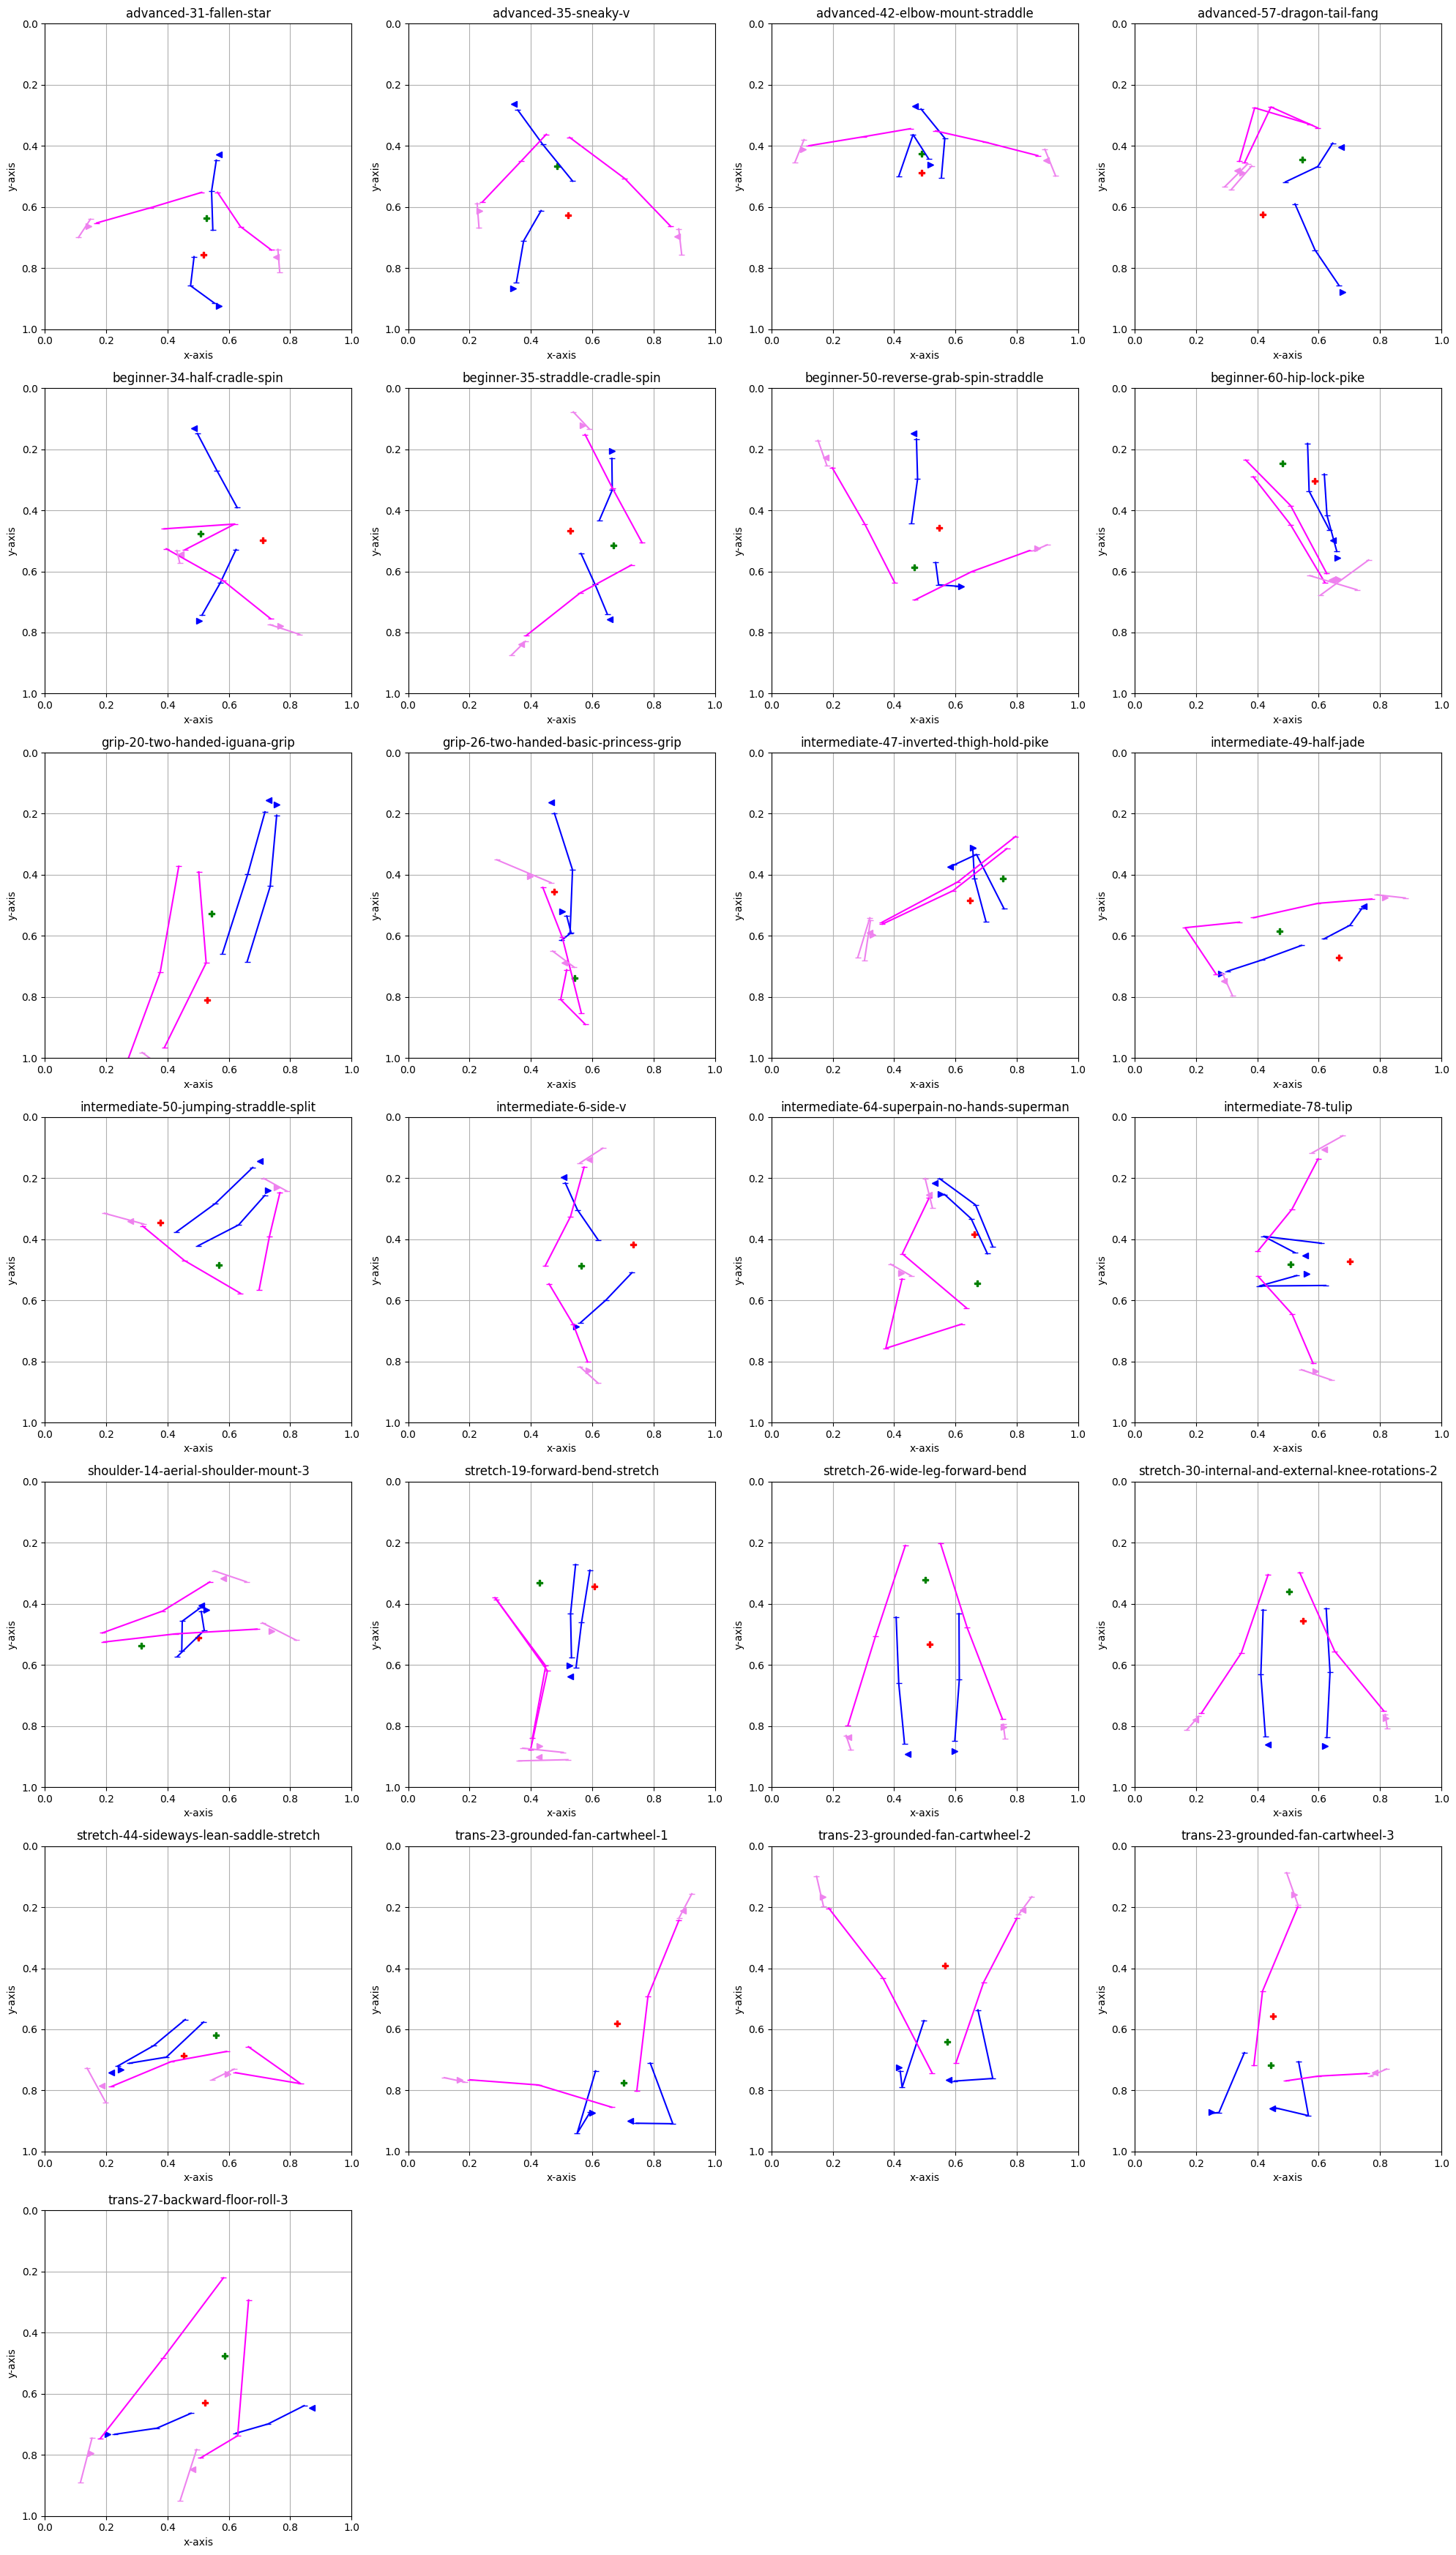

In [48]:
batch_plot_pose_landmarks_agg('data/processed/spatial_orientation_1115/undefined', '')